In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

In [2]:
basedir = '/home/jp/Documents/DESY/cross_sections'
fname = 'muon_CC/am_p_CC.dat'
pckl_prefix = '14'
datafile = open(os.path.join(basedir, fname))
numubar_p = np.loadtxt(datafile, ndmin=2)

basedir = '/home/jp/Documents/DESY/cross_sections'
fname = 'muon_CC/am_n_CC.dat'
pckl_prefix = '14'
datafile = open(os.path.join(basedir, fname))
numubar_n = np.loadtxt(datafile, ndmin=2)

basedir = '/home/jp/Documents/DESY/cross_sections'
fname = 'muon_CC/mn_n_CC.dat'
pckl_prefix = '14'
datafile = open(os.path.join(basedir, fname))
numu_n = np.loadtxt(datafile, ndmin=2)

basedir = '/home/jp/Documents/DESY/cross_sections'
fname = 'muon_CC/mn_p_CC.dat'
pckl_prefix = '14'
datafile = open(os.path.join(basedir, fname))
numu_p = np.loadtxt(datafile, ndmin=2)

In [3]:
# Functions for interpolation

# Connection between y_index and y_value
def ftransform(i):
    t = 0.01*i
    values = t**3 * (10. - 15.*t + 6.*t**2)
    return values
ft = ftransform(np.array(range(0, 101)))

y_to_i = interpolate.interp1d(x = ft,
                              y = range(0,101),
                              kind = 'cubic',
                              bounds_error = False,
                              fill_value = -1)

def createInterpolator(data, doFigs = True, label = ''):
    energy    = data[:,0]
    # Multiplied the total cross section times 100 to
    # change to GENIE units (10^-38)
    total_dis = data[:,1]*100.
    
    # Total cross section as f(E) integrated over 'y'
    dsdE_interp = interpolate.interp1d(x = energy,
                                       y = total_dis/energy,
                                       kind = 'cubic',
                                       bounds_error = True)    
    
    # Getting the y allowed region
    low_y = data[:,2]
    low_y = low_y.reshape(low_y.size, 1)
    delta_y = data[:,3]
    delta_y = delta_y.reshape(delta_y.size,1)
    max_y = np.max(low_y + delta_y, axis=1)
   
    # The differential cross section
    dsigma_dy = data[:,4:]
    y_values = low_y + delta_y*ft
    
    if doFigs:
        plt.plot(energy, total_dis/energy, label=label)
        plt.xscale('log')
        plt.xlabel(r'$E_\nu\,(\mathrm{GeV})$', fontsize='large')
        plt.ylabel('Cross section (pbn)', fontsize='large')
        plt.legend(loc=0)
        plt.xlim([3, 1000])
        
    # Interpolation
    # Use energy and np.arange(0,101)
    dsdy_interp = interpolate.interp2d( x = np.log10(energy),
                                 y = np.arange(0,101), 
                                 z = dsigma_dy.T, 
                                 kind='linear', 
                                 bounds_error = False, 
                                 fill_value = 0.)
    #if doFigs:
    #    plt.figure()
    #    plt.pcolor(dsigma_dy)

    # Interpolate the y limits for an arbitrary energy
    miny_fcn = interpolate.interp1d(x = np.log10(energy),
                                    y = low_y[:,0],
                                    kind='linear',
                                    bounds_error = False)
    maxy_fcn = interpolate.interp1d(x = np.log10(energy),
                                    y = max_y,
                                    kind='linear',
                                    bounds_error = False)

    return dsdE_interp, dsdy_interp, miny_fcn, maxy_fcn 

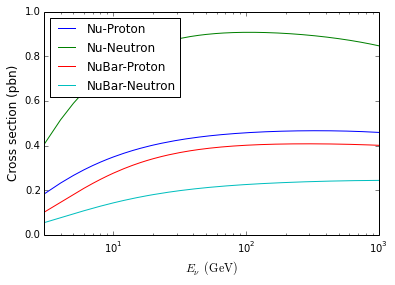

In [9]:
plt.figure()
numuP_dsdE, numuP_dsdy, numuP_miny, numuP_maxy = createInterpolator(numu_p, label = 'Nu-Proton')
numuN_dsdE, numuN_dsdy, numuN_miny, numuN_maxy = createInterpolator(numu_n, label = 'Nu-Neutron')
numubarP_dsdE, numubarP_dsdy, numubarP_miny, numubarP_maxy = createInterpolator(numubar_p, label = 'NuBar-Proton')
numubarN_dsdE, numubarN_dsdy, numubarN_miny, numubarN_maxy = createInterpolator(numubar_n, label = 'NuBar-Neutron')

In [29]:
# Main functions
def numu_n_xs(logE, y, shapeOnly = False):
    y_min = numuN_miny(logE)
    y_max = numuN_maxy(logE)
    local_deltay = y_max - y_min
    local_ft = (y - y_min)/local_deltay
    
    xs = numuN_dsdy(logE , 
                    y_to_i(local_ft).flatten())
    if shapeOnly:
        return xs
    else:
        return xs*numuN_dsdE(10**logE)#*10**logE

def numu_p_xs(logE, y, shapeOnly = False):
    y_min = numuP_miny(logE)
    y_max = numuP_maxy(logE)
    local_deltay = y_max - y_min
    local_ft = (y - y_min)/local_deltay
    xs = numuP_dsdy(logE , 
                    y_to_i(local_ft).flatten())
    if shapeOnly:
        return xs
    else:    
        return xs*numuP_dsdE(10**logE)#*10**logE

def numubar_n_xs(logE, y, shapeOnly = False):
    y_min = numubarN_miny(logE)
    y_max = numubarN_maxy(logE)
    local_deltay = y_max - y_min
    local_ft = (y - y_min)/local_deltay
    xs = numubarN_dsdy(logE , 
                    y_to_i(local_ft).flatten())
    if shapeOnly:
        return xs
    else:    
        return xs*numubarN_dsdE(10**logE)#*10**logE

def numubar_p_xs(logE, y, shapeOnly = False):
    y_min = numubarP_miny(logE)
    y_max = numubarP_maxy(logE)
    local_deltay = y_max - y_min
    local_ft = (y - y_min)/local_deltay
    xs = numubarP_dsdy(logE , 
                    y_to_i(local_ft).flatten())
    if shapeOnly:
        return xs
    else:    
        return xs*numubarP_dsdE(10**logE)#*10**logE

In [10]:
evalues = np.linspace(0.5, 3, 51)
yvalues = np.linspace(0, 1., 41)

plt.figure()
numu_p_result = np.zeros([evalues.size, yvalues.size])
numu_n_result = np.zeros_like(numu_p_result)
numubar_n_result = np.zeros_like(numu_p_result)
numubar_p_result = np.zeros_like(numu_p_result)

shape = False

for ei, energy in enumerate(evalues):
    for yi, y in enumerate(yvalues):
        #print energy, y
        numu_p_result[ei,yi] = numu_p_xs(energy, y,
                                         shapeOnly = shape)
        numu_n_result[ei,yi] = numu_n_xs(energy, y,
                                         shapeOnly = shape)
        numubar_p_result[ei,yi] = numubar_p_xs(energy, y,
                                               shapeOnly = shape)
        numubar_n_result[ei,yi] = numubar_n_xs(energy, y,
                                         shapeOnly = shape)



NameError: name 'numu_p_xs' is not defined

<matplotlib.colorbar.Colorbar instance at 0x7f3adead17a0>

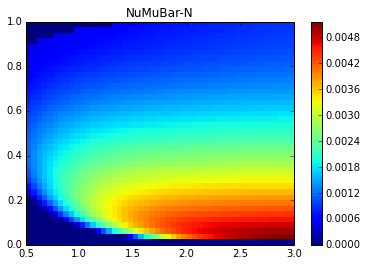

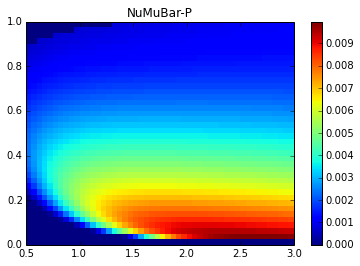

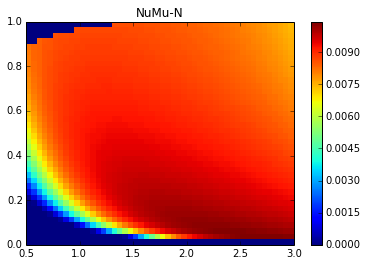

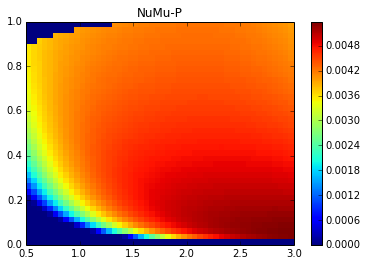

In [34]:
plt.figure()
plt.pcolor(evalues, yvalues, numubar_n_result.T)#,vmin=0, vmax = 2.5)
plt.title('NuMuBar-N')
plt.colorbar()

plt.figure()
plt.pcolor(evalues, yvalues, numubar_p_result.T)#,vmin=0, vmax = 2.5)
plt.title('NuMuBar-P')
plt.colorbar()
plt.figure()
plt.pcolor(evalues, yvalues, numu_n_result.T)#,vmin=0, vmax = 2.5)
plt.title('NuMu-N')
plt.colorbar()
plt.figure()
plt.pcolor(evalues, yvalues, numu_p_result.T)#,vmin=0, vmax = 2.5)
plt.title('NuMu-P')
plt.colorbar()

In [3]:
fudge=100
energy = numu_p[:,0]
total_dis_numu_p = numu_p[:,1]*fudge
total_dis_numu_n = numu_n[:,1]*fudge
total_dis_numubar_p = numubar_p[:,1]*fudge
total_dis_numubar_n = numubar_n[:,1]*fudge

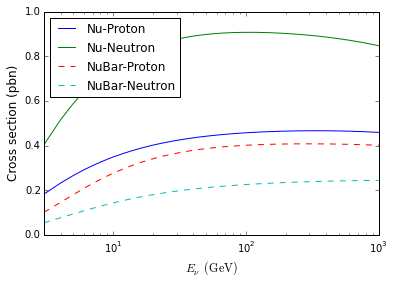

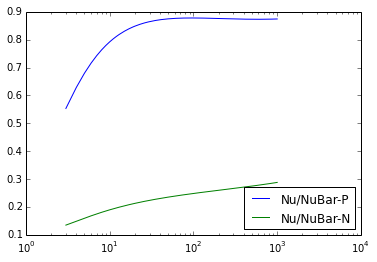

In [4]:
# Checking the total cross section vs E
plt.plot(energy, total_dis_numu_p/energy, label='Nu-Proton')
plt.plot(energy, total_dis_numu_n/energy, label='Nu-Neutron')
plt.plot(energy, total_dis_numubar_p/energy,'--', 
         label='NuBar-Proton')
plt.plot(energy, total_dis_numubar_n/energy, '--',
         label='NuBar-Neutron')

#plt.plot(energy, dsdE_interp(energy), '--r')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$E_\nu\,(\mathrm{GeV})$', fontsize='large')
plt.ylabel('Cross section (pbn)', fontsize='large')
plt.legend(loc=0)
#plt.ylim([4E-4, 1E-2])
plt.xlim([3, 1000])

plt.figure()
plt.plot(energy,total_dis_numubar_p/total_dis_numu_p, label='Nu/NuBar-P')
plt.plot(energy,total_dis_numubar_n/total_dis_numu_n, label='Nu/NuBar-N')
plt.legend(loc=0)
plt.xscale('log')


In [5]:
total_dis_neutron = total_dis/energy

NameError: name 'total_dis' is not defined

In [6]:
# Parameterization - 
# Get the interpolation for the values where the grid is almost symmetric. 
# Transform the values afterwards.

def ftransform(i):
    t = 0.01*i
    values = t**3 * (10. - 15.*t + 6.*t**2)
    return values
fvalues = ftransform(np.array(range(0, 101)))
y_to_i = interpolate.interp1d(x = fvalues,
                              y = range(0,101),
                              kind = 'cubic',
                              bounds_error = True)


# Use energy and np.arange(0,101)
dsdy_interp = interpolate.interp2d( x = np.log10(energy),
                             y = np.arange(0,101), 
                             z = dsigma_dy.T, 
                             kind='linear', 
                             bounds_error = False, 
                             fill_value = 0.)

# Interpolate the y limits for an arbitrary energy
miny_fcn = interpolate.interp1d(x = np.log10(energy),
                                y = np.log10(low_y[:,0]),
                                kind='linear',
                                bounds_error = False)
maxy_fcn = interpolate.interp1d(x = np.log10(energy),
                                y = np.log10(max_y),
                                kind='linear',
                                bounds_error = False)

# Main functions
def dsdy_xs(logE, y):
    # First transform the y asked for into the i-th bin
    y_min = 10**(miny_fcn(logE))
    y_max = 10**(maxy_fcn(logE))
    local_deltay = y_max - y_min
    local_ft = (y - y_min)/local_deltay
    xs = dsdy_interp(logE , 
                     y_to_i(local_ft).flatten())
    return xs
    #print local_ft, y_to_i(local_ft)

NameError: name 'dsigma_dy' is not defined

In [7]:
# Checking the entire dsigma/dy
plt.figure()
plt.pcolor(np.log10(energy_values), y_values, dsigma_dy,
           vmin=0, vmax = 2.5)
plt.colorbar()
plt.ylabel('y')
plt.xlabel('log10(E/GeV)')
plt.xlim([0.5, 3])

plt.figure()
ebins = 1000
ybins = 100
logE = np.linspace(np.log10(3.5), 3, ebins)
intfig = np.zeros([ebins, ybins])
yvalues   = np.zeros_like(intfig)
for ei, oneE in enumerate(logE):
    #print miny_fcn(oneE), maxy_fcn(oneE)
    yvalues[ei,:] = np.linspace(10**miny_fcn(oneE), 10**maxy_fcn(oneE), ybins)
    intfig[ei,:] = dsdy_xs(oneE, yvalues[ei,:])[:,0]

plt.pcolor(logE.reshape(ebins,1)*np.ones([1,ybins]), yvalues, intfig, vmin=0, vmax=2.5)
plt.colorbar()


NameError: name 'energy_values' is not defined

Energy  4.0
Total DIS Askhat 0.00307907
1.00196344655


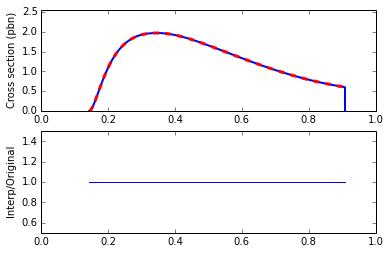

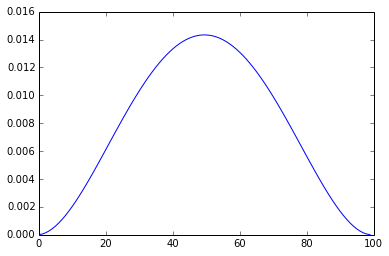

In [104]:
# Checking at an arbitrary energy index
index = 1
edelta = 0.
print 'Energy ', energy[index]
original =  dsigma_dy[index,:]
myint    =  dsdy_xs(np.log10(energy[index]+edelta), 
                    y_values[index,1:-1])

fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot(y_values[index,:],
         original, linewidth=2)
plt.plot(y_values[index,1:-1], 
         myint,
         '--r', linewidth=3)
plt.ylim([0, original.max()*1.3])
plt.ylabel('Cross section (pbn)')
ax2 = fig.add_subplot(212, sharex=ax)
#print myint, original
plt.plot(y_values[index,1:-1], original[1:-1]/myint[:,0])
#plt.xlim([y_values[index,1:-1].min(), y_values[index,1:-1].max()])
plt.ylim([0.5, 1.5])
plt.xlim([0, 1])
plt.ylabel('Interp/Original')

print 'Total DIS Askhat', total_dis[index]
plt.figure()
intervals = y_values[index,1:] - y_values[index,:-1]
plt.plot(intervals)
print np.sum(original[:-1] *intervals)

Askhat XS  0.01436814
0.0143407232456
Askhat XS  0.02504026
0.024974050193
Askhat XS  0.0823081252555
0.082277920525


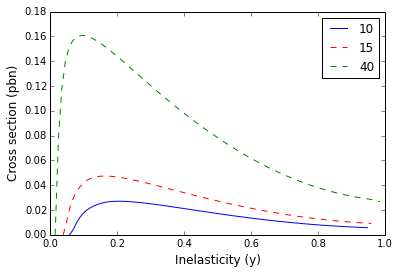

In [150]:
# Checking one energy bin vs y
energy = 10
logE = np.log10(energy)
ystep = 0.01
ylist = np.arange(10**(miny_fcn(logE)+0.001),
                  10**(maxy_fcn(logE)-0.001),
                  ystep)

xsec = dsdy_xs(logE,ylist)
total_xs = dsdE_interp(energy)*energy

plt.plot(ylist, xsec*total_xs, label = "%i" % energy)
plt.xlabel('Inelasticity (y)', fontsize='large')
plt.ylabel('Cross section (pbn)', fontsize='large')
plt.xlim([0, 1.])
print 'Askhat XS ', total_xs
print np.sum(xsec*ystep)*total_xs

energy = 15
logE = np.log10(energy)
ystep = 0.01
ylist = np.arange(10**(miny_fcn(logE)+0.001),
                  10**(maxy_fcn(logE)-0.001),
                  ystep)

xsec = dsdy_xs(logE,ylist)
total_xs = dsdE_interp(energy)*energy

plt.plot(ylist, xsec*total_xs, '--r', label = "%i" % energy)
plt.xlabel('Inelasticity (y)', fontsize='large')
plt.ylabel('Cross section (pbn)', fontsize='large')
plt.xlim([0, 1.])
print 'Askhat XS ', total_xs
print np.sum(xsec*ystep)*total_xs


energy = 40
logE = np.log10(energy)
ystep = 0.01
ylist = np.arange(10**(miny_fcn(logE)+0.001),
                  10**(maxy_fcn(logE)-0.001),
                  ystep)

xsec = dsdy_xs(logE,ylist)
total_xs = dsdE_interp(energy)*energy

plt.plot(ylist, xsec*total_xs, '--g', label = "%i" % energy)
plt.xlabel('Inelasticity (y)', fontsize='large')
plt.ylabel('Cross section (pbn)', fontsize='large')
plt.xlim([0, 1.])
print 'Askhat XS ', total_xs
print np.sum(xsec*ystep)*total_xs
plt.legend(loc=0)
#plt.ylim([0, 2.5])